In [65]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data.sampler import SubsetRandomSampler
import os
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from PIL import Image
from torch.autograd import Variable
import zipfile
from torch.utils.data import DataLoader


In [7]:
#ZIP dataset UNZIP CODE SECTION
file_name = '/content/udita.zip'
with zipfile.ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print(os.getcwd())
print('Done')

/content
Done


In [ ]:

def process_data(datadir, valid_size = 0.25, batch_size = 256):
    
    train_transforms = transforms.Compose([transforms.Resize(227),
                                               transforms.RandomRotation(degrees=30),
                                               transforms.RandomHorizontalFlip(), 
                                               transforms.ColorJitter(hue=.1, saturation=.1),
                                               transforms.ToTensor(),])
    test_transforms = transforms.Compose([transforms.Resize(227),transforms.ToTensor(),])
    
    train_data = datasets.ImageFolder(datadir, transform=train_transforms)
    test_data = datasets.ImageFolder(datadir, transform=test_transforms)
    
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size*num_train))
    np.random.shuffle(indices)
    train_idx,test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    
    trainloader = torch.utils.data.DataLoader(train_data, sampler = train_sampler, batch_size = batch_size)
    testloader = torch.utils.data.DataLoader(test_data, sampler = test_sampler, batch_size = batch_size)
    
    return trainloader,testloader

In [67]:
#Dataloader

#Path for training and testing directory
train_path='../content/udita/train'
test_path='../content/udita/validation'

transformer = transforms.Compose([transforms.Resize(227),
                                               transforms.RandomRotation(degrees=30),
                                               transforms.RandomHorizontalFlip(), 
                                               transforms.ColorJitter(hue=.1, saturation=.1),
                                               transforms.ToTensor(),])

test_transforms = transforms.Compose([transforms.Resize(227),transforms.ToTensor(),])

train_loader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=256, shuffle=True
)
test_loader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=test_transforms),
    batch_size=256, shuffle=True
)

In [68]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()  
    
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=1, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 48, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),          
            nn.Conv2d(48, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),           
            nn.Conv2d(64, 96, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(4704, 1024),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(128, 2),
        )    
        self.init_bias()
    
    def init_bias(self):
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)        
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x


In [69]:
torch.cuda.empty_cache()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_Model().to(device)

In [71]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss()

In [72]:
def accuracy(fp,y):
    preds = fp.max(1, keepdim=True)[1]
    correct = preds.eq(y.view_as(preds)).sum()
    acc = correct.float()/preds.shape[0]
    return acc

In [73]:
def train(model, device, data_itr, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.train()
    for x,y in data_itr:
        x = x.to(device)
        y = y.to(device)
        
        optimizer.zero_grad()
        fp = model(x)
        loss = criterion(fp,y)
        acc = accuracy(fp,y)
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += float(loss.item())
        epoch_acc += float(acc.item())
    return epoch_loss / len(data_itr), epoch_acc / len(data_itr)

In [74]:
def evaluate(model, device, data_itr, criterion):
    epoch_loss = 0
    epoch_acc = 0
    
    model.eval()
    with torch.no_grad():
        for x,y in data_itr:
            x = x.to(device)
            y = y.to(device)
            
            fp = model(x)
            loss = criterion(fp,y)
            acc = accuracy(fp,y)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    
    return epoch_loss / len(data_itr), epoch_acc / len(data_itr)

In [ ]:
epochs = 100
SAVE_DIR = 'models'
CKPT_SAVE_PATH = os.path.join(SAVE_DIR, 'cnn_crack_SDNET.pth.tar')
MODEL_SAVE_PATH = os.path.join(SAVE_DIR, 'cnn_crack_SDNET_model.pt')

best_val_loss = float('inf')

if not os.path.isdir(f'{SAVE_DIR}'):
     os.makedirs(f'{SAVE_DIR}')

Epochs = []
Training_loss = []
Training_accuracy = []
Validation_loss = []
Validation_accuracy = []
    
for epoch in range(epochs):
    to = time.time()
    train_loss,train_acc = train(model, device, train_loader, optimizer, criterion)
    val_loss,val_acc = evaluate(model, device, test_loader, criterion)
    tepoch = time.time() - to
    
    Epochs.append(epoch+1)
    Training_loss.append(train_loss)
    Training_accuracy.append(train_acc)
    Validation_accuracy.append(val_acc)
    Validation_loss.append(val_loss)
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_epoch = epoch+1
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        
    if epoch%50 == 0:
        torch.save({
            'epoch': Epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': Training_loss,
            'valid_loss': Validation_loss,
            'train_acc': Training_accuracy,
            'val_acc': Validation_accuracy,
            }, CKPT_SAVE_PATH)
        
    print("Epoch: %4d | Training loss: %.3f | Training Accuracy: %5.2f | Valid_loss: %.3f | Valid_accuracy: %5.2f | Time: %.3fsec" %(epoch+1, train_loss, train_acc*100, val_loss, val_acc*100, tepoch))  

Epoch:    1 | Training loss: 0.760 | Training Accuracy: 53.93 | Valid_loss: 0.710 | Valid_accuracy: 49.86 | Time: 97.129sec
Epoch:    2 | Training loss: 0.679 | Training Accuracy: 57.50 | Valid_loss: 0.682 | Valid_accuracy: 57.07 | Time: 96.285sec
Epoch:    3 | Training loss: 0.678 | Training Accuracy: 58.35 | Valid_loss: 0.734 | Valid_accuracy: 50.65 | Time: 96.216sec
Epoch:    4 | Training loss: 0.675 | Training Accuracy: 58.81 | Valid_loss: 0.702 | Valid_accuracy: 51.89 | Time: 95.683sec
Epoch:    5 | Training loss: 0.671 | Training Accuracy: 60.53 | Valid_loss: 0.974 | Valid_accuracy: 50.11 | Time: 95.630sec
Epoch:    6 | Training loss: 0.662 | Training Accuracy: 61.95 | Valid_loss: 0.779 | Valid_accuracy: 50.62 | Time: 95.989sec
Epoch:    7 | Training loss: 0.652 | Training Accuracy: 63.13 | Valid_loss: 0.795 | Valid_accuracy: 51.82 | Time: 95.661sec
Epoch:    8 | Training loss: 0.646 | Training Accuracy: 63.66 | Valid_loss: 1.023 | Valid_accuracy: 51.89 | Time: 95.578sec


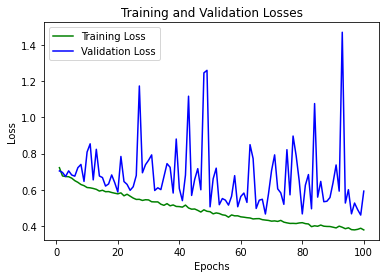

In [16]:
#Plotting graphs
#Loss curves
plt.plot(Epochs, Training_loss, 'g', label='Training Loss')
plt.plot(Epochs, Validation_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig('SDNET_loss.png')
plt.show()

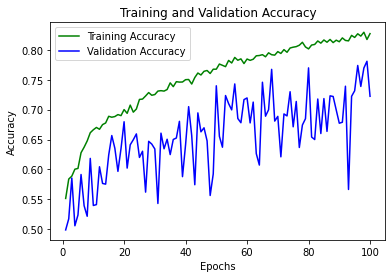

In [17]:
#Accuracy Curves 
plt.plot(Epochs, Training_accuracy, 'g', label='Training Accuracy')
plt.plot(Epochs, Validation_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig('SDNET_accuracy.png')
plt.show()

In [20]:
checkpoint = torch.load('./models/cnn_crack_SDNET.pth.tar')
model.load_state_dict(checkpoint['model_state_dict'])
model.to('cpu')
model.eval()
with torch.no_grad():
    for x,y in test_loader:                                                                                                                                                                                                                                                                                                                                                                                                                    
        x = x.to('cpu')
        y = y.to('cpu')
        fp = model(x)
        y_pred = fp.max(1, keepdim=True)[1]
        print('Accuracy Score: ', accuracy_score(y,y_pred))
        print(confusion_matrix(y,y_pred))
        print(classification_report(y,y_pred))

Accuracy Score:  0.65234375
[[ 31  88]
 [  1 136]]
              precision    recall  f1-score   support

           0       0.97      0.26      0.41       119
           1       0.61      0.99      0.75       137

    accuracy                           0.65       256
   macro avg       0.79      0.63      0.58       256
weighted avg       0.78      0.65      0.59       256

Accuracy Score:  0.65625
[[ 43  85]
 [  3 125]]
              precision    recall  f1-score   support

           0       0.93      0.34      0.49       128
           1       0.60      0.98      0.74       128

    accuracy                           0.66       256
   macro avg       0.77      0.66      0.62       256
weighted avg       0.77      0.66      0.62       256

Accuracy Score:  0.62109375
[[ 37  90]
 [  7 122]]
              precision    recall  f1-score   support

           0       0.84      0.29      0.43       127
           1       0.58      0.95      0.72       129

    accuracy                    

In [53]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob
import cv2, pandas

In [54]:
train_path='../content/udita/train'
pred_path='../content/udita/test'

In [55]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
print(classes)

['cracked', 'uncracked']


In [56]:
class CNN_Model(nn.Module):
    def __init__(self):
        super().__init__()  
    
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, padding=1, stride=2),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 48, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(48),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),          
            nn.Conv2d(48, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),           
            nn.Conv2d(64, 96, kernel_size=5, padding=2, stride=1),
            nn.BatchNorm2d(96),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(4704, 1024),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(1024, 128),
            nn.ReLU(inplace=False),
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(128, 2),
        )    
        self.init_bias()
    
    def init_bias(self):
        for layer in self.features:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)        
    
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [57]:
checkpoint=torch.load('../content/models/cnn_crack_SDNET_model.pt')
model=ConvNet(num_classes=2)
#model.load_state_dict(checkpoint)
model.load_state_dict(checkpoint, strict=False)
model.eval()

ConvNet(
  (conv1): Conv2d(3, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(12, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(12, 20, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu2): ReLU()
  (conv3): Conv2d(20, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (fc): Linear(in_features=180000, out_features=2, bias=True)
)

In [58]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])

In [59]:
#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred

images_path=glob.glob(pred_path+'/*.jpg')

pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)


In [52]:
pred_dict

{'344.jpg': 'uncracked',
 '1175.jpg': 'cracked',
 '916.jpg': 'uncracked',
 '1405.jpg': 'cracked',
 '407.jpg': 'cracked',
 '1623.jpg': 'cracked',
 '403.jpg': 'cracked',
 '825.jpg': 'cracked',
 '1886.jpg': 'cracked',
 '1915.jpg': 'cracked',
 '1308.jpg': 'cracked',
 '342.jpg': 'uncracked',
 '679.jpg': 'cracked',
 '1479.jpg': 'cracked',
 '746.jpg': 'cracked',
 '1432.jpg': 'cracked',
 '976.jpg': 'cracked',
 '1262.jpg': 'cracked',
 '885.jpg': 'cracked',
 '1279.jpg': 'cracked',
 '1412.jpg': 'cracked',
 '1821.jpg': 'cracked',
 '1097.jpg': 'uncracked',
 '1991.jpg': 'cracked',
 '433.jpg': 'uncracked',
 '1268.jpg': 'cracked',
 '1008.jpg': 'cracked',
 '1547.jpg': 'uncracked',
 '906.jpg': 'cracked',
 '550.jpg': 'cracked',
 '204.jpg': 'cracked',
 '625.jpg': 'cracked',
 '1434.jpg': 'cracked',
 '36.jpg': 'uncracked',
 '1410.jpg': 'cracked',
 '1049.jpg': 'cracked',
 '1746.jpg': 'cracked',
 '1324.jpg': 'cracked',
 '537.jpg': 'cracked',
 '1039.jpg': 'cracked',
 '1040.jpg': 'cracked',
 '1718.jpg': 'uncrac

In [62]:
f = open("data_l.txt",'w')
f.write(str(pred_dict))
f.close()

In [64]:
con_list = list(pred_dict.items())

df_again = pandas.DataFrame(con_list, columns =['filename', 'class']) 
df_again.to_csv("data_l.csv", index = False)
